**Note:** Please follow the instructions in "Preparation for running the demo on Colab" section of ``README.md`` before running this notebook!

## Initialize environment ##

In [0]:
!nvidia-smi

Wed Mar 18 19:41:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# modify the path in this block

import os
os.chdir('./drive/My Drive/vist')

In [0]:
!pip install nltk==3.4.5
!pip install transformers==2.5.1
import nltk
nltk.download('punkt')
!unzip -d /tmp ./data/test.zip
!ls /tmp/resizedtest | wc -l

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449907 sha256=f5756d4f8e0a9a87416d9847cb19253bcb51fa388c537210829a54762d5061ab
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 49.1MB/s 
     |████████████████████████████████| 3.7MB 44.7MB/s 
     |████████████████████████████████| 870kB 34.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=3d78217a068482056696724b5d29e92b9610ee990ad65ab83bd6b5ae7cf40f7e
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /tmp/resizedtest/562520848.jpg  
  inflating: /tmp/resizedtest/562523350.jpg  
  inflating: /tmp/resizedtest/562526892.jpg  
  inflating: /tmp/resizedtest/562530414.jpg  
  inflating: /tmp/resizedtest/562531866.jpg  
  inflating: /tmp/resizedtest/562537496.jpg  
  inflating: /tmp/resizedtest/562539306.jpg  
  inflating: /tmp/resizedtest/562541804.jpg  
  inflating: /tmp/resizedtest/562549960.jpg  
  inflating: /tmp/resizedtest/562553404.jpg  
  inflating: /tmp/resizedtest/562559554.jpg  
  inflating: /tmp/resizedtest/562571072.jpg  
  inflating: /tmp/resizedtest/562574506.jpg  
  inflating: /tmp/resizedtest/562578780.jpg  
  inflating: /tmp/resizedtest/562578948.jpg  
  inflating: /tmp/resizedtest/562589360.jpg  
  inflating: /tmp/resizedtest/562593322.jpg  
  inflating: /tmp/resizedtest/562598998.jpg  
  inflating: /tmp/resizedtest/5626657525.jpg  
  inflating: /tmp/resizedtest/5626785329.jpg  
  inflating: /tmp/resizedtest/5626792975.jpg  
  in

## Code ##

In [0]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle
import random
import os
from torch.autograd import Variable 
from torchvision import transforms
from data_loader import VistDataset
from build_vocab import Vocabulary
from Transformer_model_xl import DecoderStory, EncoderStory
from PIL import Image
import yaml

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from disp_multiple_images import show_images
%matplotlib inline

In [0]:
def transform_image(image, transform=None):
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [0]:
image_dir = '/tmp/resizedtest'
sis_path = './data/sis/test.story-in-sequence.json'
encoder_path = './models/encoder-xl-v2.pkl'
decoder_path = './models/decoder-xl-v2.pkl'
vocab_path = './models/vocab.pkl'
config_path = './config/config.yaml'

img_feature_size = 1024
embed_size = 256
hidden_size = 1024
mem_len = 50

In [0]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
with open(config_path, 'r') as f:
    config = yaml.load(f)

vist = VistDataset(image_dir, sis_path, vocab)

In [0]:
encoder = EncoderStory(img_feature_size, config)
decoder = DecoderStory(embed_size, img_feature_size, hidden_size, 4, 2, mem_len, vocab, config)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

encoder.eval()
decoder.eval()

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [0]:
images, targets, photo_sequences, album_ids = vist.GetItem(1300)

image_tensor = []
for image in images:
    image = transform_image(image, transform)
    image_tensor.append(image)

image_tensor = torch.stack(image_tensor).squeeze(1).unsqueeze(0)
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()

feature, _ = encoder(image_tensor)
inference_results = decoder.inference(feature.squeeze(0))

sentences = []
target_sentences = []
descriptions = []

for i, result in enumerate(inference_results):
    words = []
    for word_id in result:
        word = vocab.idx2word[word_id.cpu().item()]
        words.append(word)
        if word == '<end>':
            break
            
    words.remove('<start>')
    try:
        words.remove('<end>')
    except Exception:
        pass
        
    sentences.append(' '.join(words))
    
for i, target in enumerate(targets):
    words = []
    target = target.numpy()
    for word_id in target:
        word = vocab.idx2word[word_id]
        words.append(word)
        if word == '<end>':
            break
    
    words.remove('<start>')
    try:
        words.remove('<end>')
    except Exception:
        pass
    target_sentences.append(' '.join(words))
    
print(sentences)
print(target_sentences)

['the girl was dressed in a costume .', 'she was a little nervous .', 'her best friend came to celebrate .', 'all of the kids were excited for their big day .', 'they had a great time at the school .']
['there were a lot of children that came by my house last halloween .', 'there were so many pretty costumes .', 'some of them were scary too .', 'i had to hand out a lot of candy .', "this year i 'm going to be prepared and buy a lot more candy ."]


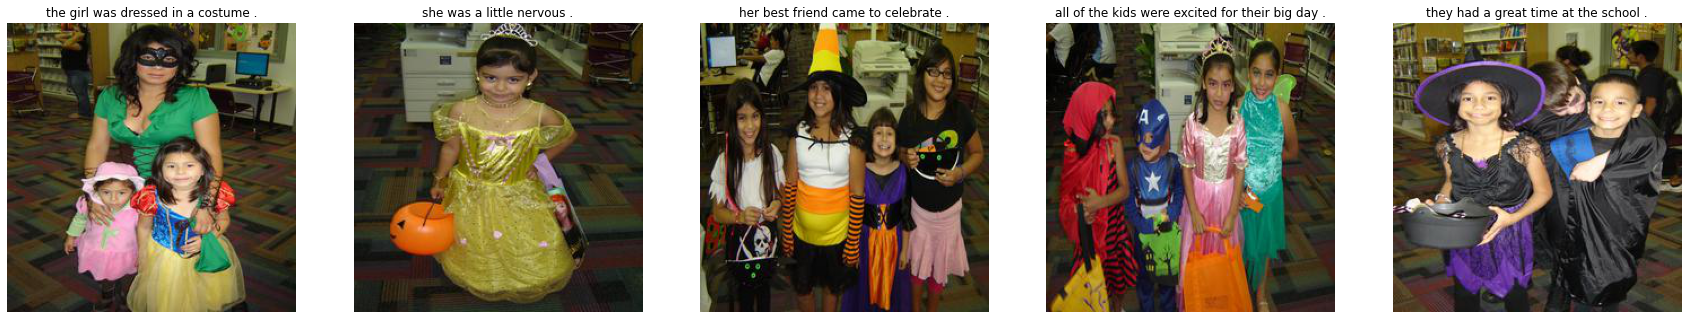

Ground truth sentences:
there were a lot of children that came by my house last halloween .
there were so many pretty costumes .
some of them were scary too .
i had to hand out a lot of candy .
this year i 'm going to be prepared and buy a lot more candy .


In [0]:
imgs_show = []
text_show = []
for data in zip(images, sentences):
    imgs_show.append(np.asarray(data[0]))
    text_show.append(data[1])
    
show_images(imgs_show, titles=text_show)
print('Ground truth sentences:')
for sentence in target_sentences:
    print(sentence)